# <center>Lecture about Geopandas and Folium </center>
# <center>Visualize OpenAQ Data </center>
### <center>by Johannes Zipp </center>
 

<img src="../image/Emission.jpeg" width=60% align="right" style="in-line">

>*Visualisation of Emission Data.*
>
>*
Data extraction, processing, and visualization of traffic emissions practically promotes the analysis of real-world environmental issues and trains data-driven decision-making.
>
>— ChatGPT 4o
>
<img src="../image/Emissionsstatistik.jpeg" width=70% align="middle" style="in-line">

>
Statistic from 3 different german cities based on their PM2,5 and PM10 Emissions created by ChatGPT 4o.
>
>Sources:
>
>https://www.umweltbundesamt.de/daten/luft/luftschadstoff-emissionen-in-deutschland/emission-vonfeinstaub-der-partikelgroesse-pm10
>
>https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Umwelt/UGR/energiefluesse-emissionen/Tabellen/luftschadstoffe.html
>

## Learning goals

1. Data Visualization: Students will learn how to create insightful visualizations of air quality data, focusing on spatial patterns using Python libraries like GeoPandas and Matplotlib.
2. Geospatial Data Handling: Students will gain proficiency in processing and analyzing geospatial data, including filtering datasets within a bounding box and plotting data points on maps.
3. Geographical Insights: Students will develop the ability to interpret air quality variations geographically and understand how to overlay data onto real-world map visualizations

## Agenda

1. [Review: Web scraping](#1)
2. [Review: Data wrangling](#2)
3. [Geopandas](#3)
4. [Folium](#3)

## <font color=dodgerblue> Information

**<font color=dodgerblue> What's OpenAQ?: </font>** OpenAQ is a global platform that aggregates and shares air quality data from government agencies, research institutions, and other sources. It provides access to real-time and historical air pollution measurements, fostering transparency and enabling analysis of air quality trends.

**<font color=dodgerblue> Why do we need an API?: </font>**  Even though OpenAQ provides open data, an API is necessary for efficient and scalable access to that data. Open data means the information is freely available, but accessing and processing large volumes of it manually can be cumbersome and error-prone. The OpenAQ API enables users to programmatically query specific datasets.

So please visit https://openaq.org and create an free account to get an own API

<a name="1"></a>
## Step 1: Web scraping

In [ ]:
pip install folium # installation python package

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import csv
import pandas as pd
import json
#folium
import folium
from folium import plugins
from folium import Popup
from folium.plugins import HeatMap, MarkerCluster
from IPython.display import display
#Geopandas
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from shapely.geometry import box
from scipy.spatial import distance_matrix
#seaborn
import seaborn as sns
import matplotlib.pyplot as plt

### Step 1.1: HTML Request

In [2]:
url = "https://api.openaq.org/v2/measurements" # API-Key for authorization
headers = {
    "X-API-Key": "5ba843cc799e2acf35eb2407520ba3b699016a1cc0e465f1ccd8c9e4f34a0e0d"  
}
response = requests.get(url, headers=headers) # get request for Data

In [3]:
# check, whether request was succesuful
if response.status_code == 200:
    print("Succesful")
else:
    print("Mistake: {response.status_code}, {response.text}")

Succesful



### Step 1.2: Parse

In [4]:
# Pars the JSON-Data
data = response.json()
soup = BeautifulSoup(json.dumps(data), "html.parser")

In [5]:
# First Debugging: Data structure check
print(soup.prettify()[:1000])  # First 1000 marks

{"meta": {"name": "openaq-api", "license": "", "website": "/", "page": 1, "limit": 100, "found": "&gt;100"}, "results": [{"locationId": 26, "location": "Inpesca", "parameter": "pm10", "value": 36.0, "date": {"utc": "2024-12-04T07:00:00+00:00", "local": "2024-12-04T04:00:00-03:00"}, "unit": "\u00b5g/m\u00b3", "coordinates": {"latitude": -36.737202, "longitude": -73.104427}, "country": "CL", "city": null, "isMobile": false, "isAnalysis": null, "entity": "Governmental Organization", "sensorType": "reference grade"}, {"locationId": 26, "location": "Inpesca", "parameter": "pm10", "value": 37.0, "date": {"utc": "2024-12-04T06:00:00+00:00", "local": "2024-12-04T03:00:00-03:00"}, "unit": "\u00b5g/m\u00b3", "coordinates": {"latitude": -36.737202, "longitude": -73.104427}, "country": "CL", "city": null, "isMobile": false, "isAnalysis": null, "entity": "Governmental Organization", "sensorType": "reference grade"}, {"locationId": 26, "location": "Inpesca", "parameter": "pm10", "value": 37.0, "date

<a name="2"></a>
## Step 2: Define Parameters

In [6]:
params = {
    "coordinates": "50.1109,8.6821",           # Coordinate of Frankfurt  Rhein-Main-Gebiet
    "radius": 25000,                           # Radius in Meter (25 km) 
    "date_from": "2024-06-22T00:00:00+00:00",  # Beginn des Tages 22.06.2024
    "date_to": "2024-06-22T23:59:59+00:00",    # Ende des Tages 22.06.2024
    "parameter": ["pm25", "pm10"],             # Only PM2.5 and PM10-Werte
    "limit": 10000                             # maximal amount of letters
}
response = requests.get(url, headers=headers, params=params)
print(response.json())  # Parameter Data Check

{'meta': {'name': 'openaq-api', 'license': '', 'website': '/', 'page': 1, 'limit': 10000, 'found': 414}, 'results': [{'locationId': 3054, 'location': 'Offenbach Untere Grenzstraße', 'parameter': 'pm10', 'value': 9.682449, 'date': {'utc': '2024-06-22T23:00:00+00:00', 'local': '2024-06-23T01:00:00+02:00'}, 'unit': 'µg/m³', 'coordinates': {'latitude': 50.101494000183585, 'longitude': 8.78489199987511}, 'country': 'DE', 'city': None, 'isMobile': False, 'isAnalysis': None, 'entity': 'Governmental Organization', 'sensorType': 'reference grade'}, {'locationId': 3054, 'location': 'Offenbach Untere Grenzstraße', 'parameter': 'pm10', 'value': 10.4575, 'date': {'utc': '2024-06-22T22:00:00+00:00', 'local': '2024-06-23T00:00:00+02:00'}, 'unit': 'µg/m³', 'coordinates': {'latitude': 50.101494000183585, 'longitude': 8.78489199987511}, 'country': 'DE', 'city': None, 'isMobile': False, 'isAnalysis': None, 'entity': 'Governmental Organization', 'sensorType': 'reference grade'}, {'locationId': 3054, 'loca

In [7]:
data = response.json()  
print(json.dumps(data, indent=2))  # Structure Check


{
  "meta": {
    "name": "openaq-api",
    "license": "",
    "website": "/",
    "page": 1,
    "limit": 10000,
    "found": 414
  },
  "results": [
    {
      "locationId": 3054,
      "location": "Offenbach Untere Grenzstra\u00dfe",
      "parameter": "pm10",
      "value": 9.682449,
      "date": {
        "utc": "2024-06-22T23:00:00+00:00",
        "local": "2024-06-23T01:00:00+02:00"
      },
      "unit": "\u00b5g/m\u00b3",
      "coordinates": {
        "latitude": 50.101494000183585,
        "longitude": 8.78489199987511
      },
      "country": "DE",
      "city": null,
      "isMobile": false,
      "isAnalysis": null,
      "entity": "Governmental Organization",
      "sensorType": "reference grade"
    },
    {
      "locationId": 3054,
      "location": "Offenbach Untere Grenzstra\u00dfe",
      "parameter": "pm10",
      "value": 10.4575,
      "date": {
        "utc": "2024-06-22T22:00:00+00:00",
        "local": "2024-06-23T00:00:00+02:00"
      },
      "unit": "\u


## Step 3: Structure Data with Pandas

In [8]:
# Extraction of the 'results' Data
records = data.get("results", [])
df = pd.DataFrame(records)  # Create a DataFrame 

# Show first Station measurements
print(df.head())


   locationId                      location parameter      value  \
0        3054  Offenbach Untere Grenzstraße      pm10   9.682449   
1        3054  Offenbach Untere Grenzstraße      pm10  10.457500   
2        3054  Offenbach Untere Grenzstraße      pm10   9.020849   
3        3054  Offenbach Untere Grenzstraße      pm10   8.588600   
4        3054  Offenbach Untere Grenzstraße      pm10   7.616199   

                                                date   unit  \
0  {'utc': '2024-06-22T23:00:00+00:00', 'local': ...  µg/m³   
1  {'utc': '2024-06-22T22:00:00+00:00', 'local': ...  µg/m³   
2  {'utc': '2024-06-22T21:00:00+00:00', 'local': ...  µg/m³   
3  {'utc': '2024-06-22T20:00:00+00:00', 'local': ...  µg/m³   
4  {'utc': '2024-06-22T19:00:00+00:00', 'local': ...  µg/m³   

                                         coordinates country  city  isMobile  \
0  {'latitude': 50.101494000183585, 'longitude': ...      DE  None     False   
1  {'latitude': 50.101494000183585, 'longitude': ...

In [9]:
# cut columns 
df = df[['date', 'parameter', 'value', 'unit', 'location', 'coordinates']]

# converte Data and remove Datetime
df['date'] = pd.to_datetime(df['date'].apply(lambda x: x.get('utc') if isinstance(x, dict) else x)).dt.date

# only interesstet in Coordinates: as a preparation for Geopandas
df['latitude'] = df['coordinates'].apply(lambda x: x['latitude'])
df['longitude'] = df['coordinates'].apply(lambda x: x['longitude'])
df = df.drop(columns='coordinates')  # Entfernt die 'coordinates'-Spalte

# Check
print(df.head())


         date parameter      value   unit                      location  \
0  2024-06-22      pm10   9.682449  µg/m³  Offenbach Untere Grenzstraße   
1  2024-06-22      pm10  10.457500  µg/m³  Offenbach Untere Grenzstraße   
2  2024-06-22      pm10   9.020849  µg/m³  Offenbach Untere Grenzstraße   
3  2024-06-22      pm10   8.588600  µg/m³  Offenbach Untere Grenzstraße   
4  2024-06-22      pm10   7.616199  µg/m³  Offenbach Untere Grenzstraße   

    latitude  longitude  
0  50.101494   8.784892  
1  50.101494   8.784892  
2  50.101494   8.784892  
3  50.101494   8.784892  
4  50.101494   8.784892  


<a name="3"></a>
## Step 4: Geopandas 

<img src="../image/geopandas.png" width=40% align="right" style="in-line">

>*What's Geopandas?*
>
>*
GeoPandas is a library designed to make working with geospatial data easier. It extends the capabilities of pandas by adding support for spatial operations, enabling manipulation of geometries like points, lines, and polygons. GeoPandas allows users to perform complex geographic analyses and visualize geospatial data directly in Python.


>
>— ChatGPT 4o

>
Our Goals for this exercise:
>
>*
Create Geom
>
>*
Calculate Distances 
>
>*
First Visualisation 
>
>*
Create a Matrix based on dependencies



In [10]:
# From the preperated GeoData we create a GeomFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Check
print(geo_df.head())


         date parameter      value   unit                      location  \
0  2024-06-22      pm10   9.682449  µg/m³  Offenbach Untere Grenzstraße   
1  2024-06-22      pm10  10.457500  µg/m³  Offenbach Untere Grenzstraße   
2  2024-06-22      pm10   9.020849  µg/m³  Offenbach Untere Grenzstraße   
3  2024-06-22      pm10   8.588600  µg/m³  Offenbach Untere Grenzstraße   
4  2024-06-22      pm10   7.616199  µg/m³  Offenbach Untere Grenzstraße   

    latitude  longitude                  geometry  
0  50.101494   8.784892  POINT (8.78489 50.10149)  
1  50.101494   8.784892  POINT (8.78489 50.10149)  
2  50.101494   8.784892  POINT (8.78489 50.10149)  
3  50.101494   8.784892  POINT (8.78489 50.10149)  
4  50.101494   8.784892  POINT (8.78489 50.10149)  


In [11]:
geo_df.set_crs(epsg=4326, inplace=True) # Row and Column check

,date,parameter,value,unit,location,latitude,longitude,geometry
0,2024-06-22,pm10,9.682449,µg/m³,Offenbach Untere Grenzstraße,50.101494,8.784892,POINT (8.78489 50.10149)
1,2024-06-22,pm10,10.457500,µg/m³,Offenbach Untere Grenzstraße,50.101494,8.784892,POINT (8.78489 50.10149)
2,2024-06-22,pm10,9.020849,µg/m³,Offenbach Untere Grenzstraße,50.101494,8.784892,POINT (8.78489 50.10149)
3,2024-06-22,pm10,8.588600,µg/m³,Offenbach Untere Grenzstraße,50.101494,8.784892,POINT (8.78489 50.10149)
4,2024-06-22,pm10,7.616199,µg/m³,Offenbach Untere Grenzstraße,50.101494,8.784892,POINT (8.78489 50.10149)
...,...,...,...,...,...,...,...,...
409,2024-06-22,pm10,4.104167,µg/m³,Hauptstraße Oberstedten,50.226631,8.564387,POINT (8.56439 50.22663)
410,2024-06-22,pm10,3.187500,µg/m³,Hauptstraße Oberstedten,50.226631,8.564387,POINT (8.56439 50.22663)
411,2024-06-22,pm10,2.187500,µg/m³,Hauptstraße Oberstedten,50.226631,8.564387,POINT (8.56439 50.22663)
412,2024-06-22,pm10,2.125000,µg/m³,Hauptstraße Oberstedten,50.226631,8.564387,POINT (8.56439 50.22663)


In [12]:
# Mean-Value for every meaasurement location !not Geopandas specific but neccesary for next steps!
average_by_location = geo_df.groupby(["location", "parameter"])["value"].mean().unstack()
print("Durchschnittswerte pro Standort:")
print(average_by_location)

Durchschnittswerte pro Standort:
parameter                              pm10      pm25
location                                             
Frankfurt Friedberger Landstraße  10.583852  6.037641
Frankfurt Ost                      8.287076  4.898349
Frankfurt-Höchst                   8.361199  5.258967
Frankfurt-Schwanheim               7.690082  4.472784
Hanau                              7.659528  4.933641
Hauptstraße Oberstedten            5.760540  5.615283
Kleiner Feldberg                   6.187917  4.871873
Offenbach Untere Grenzstraße       8.523295  5.482976
Raunheim                           7.904352  4.895084


### Step 4.1: Creating a Box and show Locations

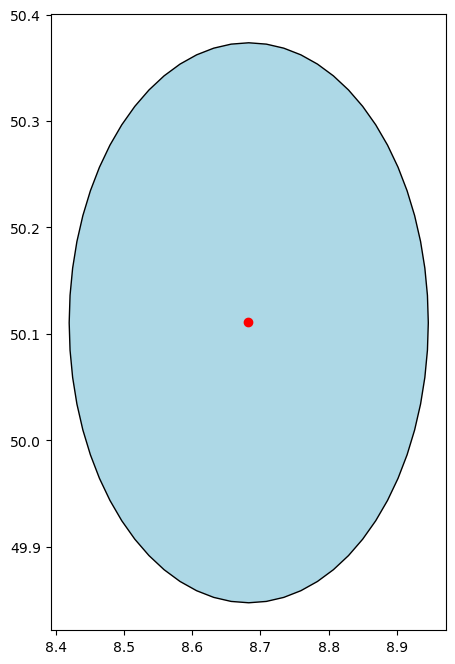

In [14]:
# center Frankfurt
center_lat = 50.1109
center_lon = 8.6821

# center point
center_point = Point(center_lon, center_lat)

# Radius of circle
radius_km = 25
radius_deg = radius_km / 95  # 1 Grad Breitengrad entspricht ca. 111 km

# Circle-Geom
circle = center_point.buffer(radius_deg)

# GeoDataFrame for circle
gdf_circle = gpd.GeoDataFrame({"geometry": [circle]}, crs="EPSG:4326")

# Plot of circle
ax=gdf_circle.plot(color="lightblue", edgecolor="black", figsize=(8, 8))

# red point as center
ax.scatter(center_lon, center_lat, color="red", marker="o", label="Center", zorder=5)

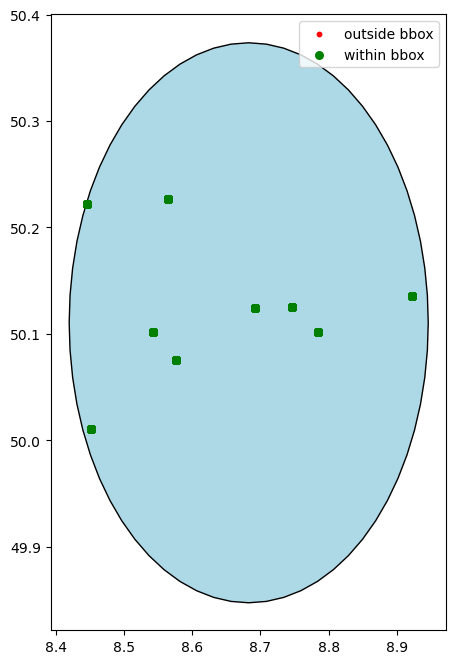

In [15]:
# GeoDataFrame for all points
gdf_points = gpd.GeoDataFrame(
    geo_df,
    geometry=gpd.points_from_xy(geo_df["longitude"], geo_df["latitude"]),
    crs="EPSG:4326"
)

# filter points within the circle
gdf_points_in_circle = gdf_points[gdf_points.geometry.within(circle)]


# plot circle and points
ax = gdf_circle.plot(color="lightblue", edgecolor="black", figsize=(8, 8))
gdf_points.plot(ax=ax, color="red", markersize=10, label="outside bbox")
gdf_points_in_circle.plot(ax=ax, color="green", markersize=30, label="within bbox")

# Legend
ax.legend()


### Step 4.2: First Visualisation of Measurements

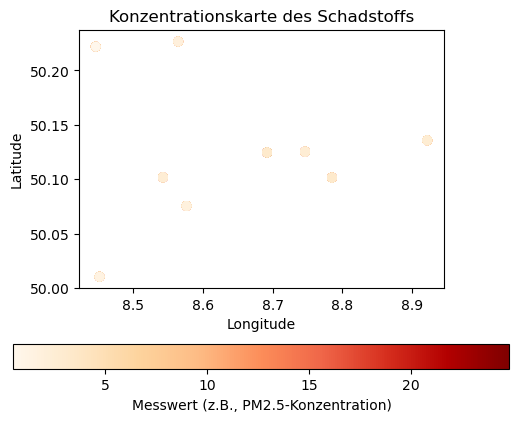

In [16]:
# ColourScale
geo_df.plot(column='value', cmap='OrRd', legend=True, 
            legend_kwds={'label': "Messwert (z.B., PM2.5-Konzentration)", 'orientation': "horizontal"})

# Map shows the maximum/minimum Latitude and Longitude
plt.title("Konzentrationskarte des Schadstoffs")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Step 4.3: Create a Matrix based on Distance

CRS bereits gesetzt: EPSG:4326
Distanzmatrix zwischen einzigartigen Messstationen (in Kilometern):
location                          Offenbach Untere Grenzstraße      Hanau  \
location                                                                    
Offenbach Untere Grenzstraße                          0.000000  10.512970   
Hanau                                                10.512970   0.000000   
Raunheim                                             25.993704  36.504003   
Frankfurt Friedberger Landstraße                      7.144276  16.501127   
Frankfurt-Höchst                                     17.377402  27.428834   
Frankfurt Ost                                         3.833148  12.607629   
Kleiner Feldberg                                     27.729260  35.364597   
Hauptstraße Oberstedten                              21.067553  27.497341   
Frankfurt-Schwanheim                                 15.237605  25.646961   

location                           Raunheim  Frankfur

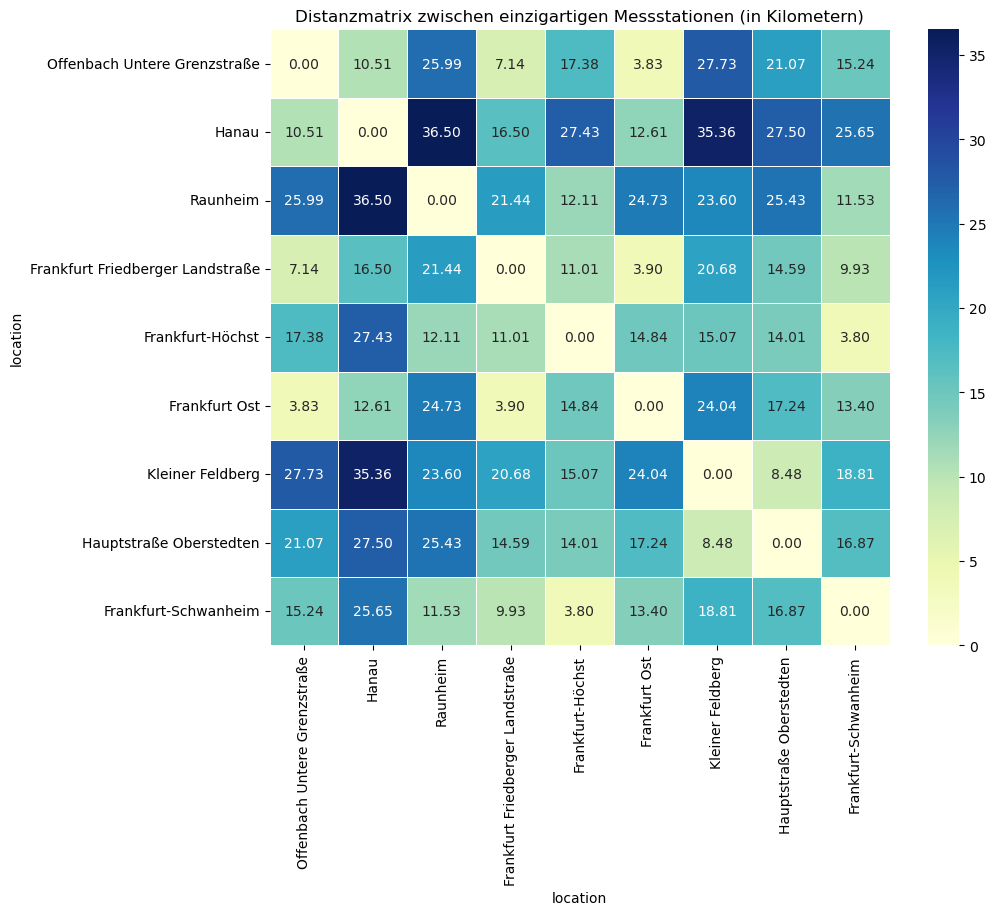

In [20]:
# Duplicated Geom reomove
unique_coords = geo_df[['location', 'geometry']].drop_duplicates(subset='location').copy()

# Check of coordinatesystem
if unique_coords.crs is None:
    unique_coords = unique_coords.set_crs("EPSG:4326")
else:
    print(f"CRS bereits gesetzt: {unique_coords.crs}")

# Converte CRS in a metrical coordinate system 
unique_coords = unique_coords.to_crs("EPSG:32633")

# Extraction of metrical coordinates
unique_coords['x'] = unique_coords.geometry.x
unique_coords['y'] = unique_coords.geometry.y

# Calculates the Distance (in Km)
dist_matrix = pd.DataFrame(
    distance_matrix(unique_coords[['x', 'y']], unique_coords[['x', 'y']]),
    index=unique_coords['location'],
    columns=unique_coords['location']
) / 1000  # Meter in Kilometer 

# Creates a Matrix
print("Distanzmatrix zwischen einzigartigen Messstationen (in Kilometern):")
print(dist_matrix)

# as Heatmap depending on Distance
plt.figure(figsize=(10, 8))
sns.heatmap(dist_matrix, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Distanzmatrix zwischen einzigartigen Messstationen (in Kilometern)")
plt.show()


<a name="4"></a>
## Step 5: Folium

<img src="../image/Folium.png" width=40% align="right" style="in-line">

>*What's Folium?*
>
>*
Folium is a library used for creating interactive maps. It generate maps that can display markers, polygons, and other geospatial data. Folium allows users to create rich, interactive visualizations that are easy to integrate into websites or Jupyter notebooks.


>
>— ChatGPT 4o

>
Our Goals for this exercise:
>
>*
Visualize Data in Maps
>
>*
Create a Clusters
>
>*
Create colour gradients to show differences
>
>*
Create a Game based on our Data


In [18]:
# Center Map on Frankfurt
map_frankfurt = folium.Map(location=[50.1109,8.6821], zoom_start=12)

# Circle around Frankfurt
folium.Circle(
    location=[50.1109,8.6821],  # Zentrum von Darmstadt
    radius=25000,  # Radius in Metern (10 km)
    color="blue",
    fill=True,
    fill_color="lightblue",
    fill_opacity=0.4
).add_to(map_frankfurt)

# Punkte zur Karte hinzufügen
for _, row in gdf_points.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(map_frankfurt)

# Karte anzeigen
map_frankfurt

### Step 5.1: Create a Map and add Data 

In [19]:
#Create a map with Frankfurt as center 
m = folium.Map(location=[50.1109, 8.6821], zoom_start=10)

# add measurement Data to the location
def add_marker(row):
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue' if row['parameter'] == 'pm25'else 'red',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['parameter']}: {row['value']} {row['unit']}"
    ).add_to(m)

geo_df.apply(add_marker, axis=1)

# show card
m.save("Frankfurt_Luftqualitaet.html")  # save map as HTML
m


### Step 5.2: Scale Values with colours and create a Legend

In [21]:
# Mittelwerte zurück in ein geeignetes Format bringen
average_df = geo_df.groupby(["location", "parameter", "latitude", "longitude"], as_index=False)["value"].mean()

# Colour Scale for PM2.5 ans PM10 Data based on intensity
def get_color(value, parameter):
    if parameter == "pm25":        # based on their governmental thresholds per day pm
        if value < 10:
            return "green"
        elif value < 25:
            return "yellow"
        elif value < 50:
            return "orange"
        else:
            return "red"
    elif parameter == "pm10":
        if value < 20:
            return "green"
        elif value < 40:
            return "yellow"
        elif value < 75:
            return "orange"
        else:
            return "red"

# create a new map for visualisation
m = folium.Map(location=[50.1109, 8.6821], zoom_start=10)

# add Measurement Data based on Scale
for _, row in average_df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=7,
        color=get_color(row["value"], row["parameter"]),
        fill=True,
        fill_opacity=0.6,
        popup=(
            f"Ort: {row['location']}<br>"
            f"{row['parameter']}: {row['value']:.2f} µg/m³<br>"  # Mittelwert
        ),
    ).add_to(m)

# add a Legend
legend_html = """
<div style="position: fixed; 
            bottom: 350px; left: 50px; width: 200px; height: 175px; 
            background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
            ">
    <h4 style="margin:10px">PM Werte (µg/m³)</h4>
    <div style="background-color:green; height:15px; width:30px; display:inline-block; margin:5px"></div><span> Gering</span><br>
    <div style="background-color:yellow; height:15px; width:30px; display:inline-block; margin:5px"></div><span> Mäßig</span><br>
    <div style="background-color:orange; height:15px; width:30px; display:inline-block; margin:5px"></div><span> Hoch</span><br>
    <div style="background-color:red; height:15px; width:30px; display:inline-block; margin:5px"></div><span> Sehr hoch</span>
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

# show map
m.save("Frankfurt_Luftqualitaet_mit_Farbskala_Mittelwert.html")
m

### Step 5.3: Cluster Data  

In [22]:
# Create a card
m = folium.Map(location=[50.1109, 8.6821], zoom_start=10)

# Cluster Group
marker_cluster = MarkerCluster().add_to(m)

# point with Colour coding and Popup for every station 
for _, row in geo_df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=7,
        color=get_color(row["value"], row["parameter"]),
        fill=True,
        fill_opacity=0.7,
        popup=(
            f"<b>Ort:</b> {row['location']}<br>"
            f"<b>{row['parameter']}:</b> {row['value']} {row['unit']}<br>"
            f"<b>Datum:</b> {row['date'].strftime('%Y-%m-%d')}"
        ),
    ).add_to(marker_cluster)

# Heatmap-Data preparation
heatmap_data = [[row["latitude"], row["longitude"], row["value"]] for _, row in geo_df.iterrows()]

# add Heatmap with adjusted `max_val` and `gradient`
HeatMap(
    data=heatmap_data,
    radius=25,
    blur=15,
    max_opacity=0.8,
    gradient={0.5: 'green', 0.7: 'yellow', 0.9: 'orange', 1.1: 'red'},
).add_to(m)

# Legend
legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: 140px; 
            background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
            padding: 10px;">
    <h4>PM Werte (µg/m³)</h4>
    <div style="background-color:green; height:15px; width:30px; display:inline-block; margin-right:10px;"></div> Geringe Belastung<br>
    <div style="background-color:yellow; height:15px; width:30px; display:inline-block; margin-right:10px;"></div> Moderate Belastung<br>
    <div style="background-color:orange; height:15px; width:30px; display:inline-block; margin-right:10px;"></div> Hohe Belastung<br>
    <div style="background-color:red; height:15px; width:30px; display:inline-block; margin-right:10px;"></div> Sehr hohe Belastung<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# show card
m.save("Frankfurt_PM_Cluster_Heatmap.html")
m

### Step 5.4 **<font color=cornflowerblue>Exercise: </font>** Play a game

In [23]:

# Punktzahlberechnung basierend auf Luftqualitätswert
def calculate_points(value, parameter):
    if parameter == "pm25":
        if value < 10:
            return 10  # Grün
        elif value < 25:
            return 5   # Gelb
        elif value < 50:
            return -5  # Orange
        else:
            return -10  # Rot
    elif parameter == "pm10":
        if value < 20:
            return 10
        elif value < 40:
            return 5
        elif value < 75:
            return -5
        else:
            return -10

# Spieler mit Startpunktzahl 0
players = {
    'Player1': 0
}

# Orte mit geographischen Daten (reale Orte)
locations = [
    # Deutschland
    {"location": "Berlin", "latitude": 52.5200, "longitude": 13.4050, "parameter": "pm25", "value": 15, "unit": "µg/m³"},
    {"location": "Hamburg", "latitude": 53.5511, "longitude": 9.9937, "parameter": "pm10", "value": 22, "unit": "µg/m³"},
    {"location": "München", "latitude": 48.1351, "longitude": 11.5820, "parameter": "pm25", "value": 30, "unit": "µg/m³"},
    {"location": "Köln", "latitude": 50.9375, "longitude": 6.9603, "parameter": "pm10", "value": 18, "unit": "µg/m³"},
    {"location": "Frankfurt", "latitude": 50.1109, "longitude": 8.6821, "parameter": "pm25", "value": 3.5, "unit": "µg/m³"},
    # International
    {"location": "Paris", "latitude": 48.8566, "longitude": 2.3522, "parameter": "pm25", "value": 12, "unit": "µg/m³"},
    {"location": "London", "latitude": 51.5074, "longitude": -0.1278, "parameter": "pm10", "value": 35, "unit": "µg/m³"},
    {"location": "New York", "latitude": 40.7128, "longitude": -74.0060, "parameter": "pm25", "value": 45, "unit": "µg/m³"},
    {"location": "Tokyo", "latitude": 35.6895, "longitude": 139.6917, "parameter": "pm10", "value": 50, "unit": "µg/m³"},
    {"location": "Sydney", "latitude": -33.8688, "longitude": 151.2093, "parameter": "pm25", "value": 7, "unit": "µg/m³"}
]

# Initialisierung der Karte
m = folium.Map(location=[50.1109, 8.6821], zoom_start=3)
marker_cluster = MarkerCluster().add_to(m)

# Spieleraktionen
max_attempts = 5
current_attempts = 0
ranking_visible = True

# Funktion zur Auswahl eines Ortes
def select_location(location):
    global current_attempts, ranking_visible
    if current_attempts < max_attempts:
        points = calculate_points(location["value"], location["parameter"])
        players["Player1"] += points
        current_attempts += 1
        if current_attempts == max_attempts:
            ranking_visible = True
        return f"Du hast {points} Punkte erhalten. Gesamtpunktzahl: {players['Player1']}"
    else:
        return "Du hast die maximale Anzahl an Versuchen erreicht!"

# Marker für Orte
for location in locations:
    popup_html = f"""
    <div>
        <strong>Ort:</strong> {location['location']}<br>
        <strong>{location['parameter']}:</strong> {location['value']} {location['unit']}<br>
        <button onclick="alert('{select_location(location)}')">Wähle diesen Ort</button>
    </div>
    """
    popup = Popup(popup_html, max_width=300)
    
    # Schwarze Marker für die Orte
    folium.CircleMarker(
        location=[location["latitude"], location["longitude"]],
        radius=10,
        color="black",
        fill=True,
        fill_opacity=0.7,
        popup=popup,
    ).add_to(marker_cluster)

# Farbliche Legende für die Punktzahlen
legend_html = """
<div style="position: fixed; bottom: 50px; right: 50px; width: 300px; height: 200px; background-color: white; border:2px solid grey; z-index:9999; font-size:14px; padding:10px;">
    <h4>Punktzahl Legende</h4>
    <ul style="list-style-type:none; padding:0; margin:0;">
        <li><span style="display:inline-block; width:20px; height:20px; background-color:green; margin-right:10px;"></span>10 Punkte</li>
        <li><span style="display:inline-block; width:20px; height:20px; background-color:yellow; margin-right:10px;"></span>5 Punkte</li>
        <li><span style="display:inline-block; width:20px; height:20px; background-color:orange; margin-right:10px;"></span>-5 Punkte</li>
        <li><span style="display:inline-block; width:20px; height:20px; background-color:red; margin-right:10px;"></span>-10 Punkte</li>
    </ul>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Rangliste aktualisieren
def update_ranking():
    if ranking_visible:
        sorted_players = sorted(players.items(), key=lambda x: x[1], reverse=True)
        rank_list_html = """
        <div style="position: fixed; bottom: 120px; left: 50px; width: 250px; height: 200px; background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
            <h4>Rangliste</h4>
        """
        
        for idx, (player, score) in enumerate(sorted_players, 1):
            rank_list_html += f"<p>{idx}. {player}: {score} Punkte</p>"
        
        rank_list_html += "</div>"
        return rank_list_html
    else:
        return """
        <div style="position: fixed; bottom: 120px; left: 50px; width: 250px; height: 50px; background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
            <p>Rangliste wird nach den 5 Versuchen angezeigt.</p>
        </div>
        """

m.get_root().html.add_child(folium.Element(update_ranking()))

# Karte speichern
m.save("Luftqualitaet_Spiel_mit_Scoreboard_und_Legende.html")
m


&#x2753;**<font color=cornflowerblue>QUESTION: </font>** Can you do it better? Try to fix the mistakes!

In [ ]:
# put your code here













---------
# Thanks for listening!

This notebook is written by [Johannes Zipp]